In [1]:
import numpy as np
import scipy as sc
import pandas as pd
import pymc3 as pm
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import csv
import itertools
%matplotlib inline

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
from os import listdir
from os.path import isfile, join
path = '../RetweetDataAOAS/retweet_data/'
root_tweet_names = [f for f in listdir(path) if isfile(join(path, f))]

In [3]:
# Produces a dictionary of dataframes for each tweetfile, with initial 
# preprocessing
fields = ['RetweetCount', 'UserId', 'ScreenName', 'FollowerCount', 
          'DistanceFromRoot','Time', 'ParentScreenName', 'Text']
tweet_dfs = {}
for i in range(len(root_tweet_names)):
    tweet_df = pd.read_csv(path+root_tweet_names[i], sep="\t", header=None, 
                         quoting=csv.QUOTE_NONE, names=fields, encoding = "ISO-8859-1")
    
    tweet_df['Time'] = pd.to_datetime(tweet_df['Time'])

    screen_name_index = {}
    for index, row in tweet_df.iterrows():
        screen_name_index[row['ScreenName']] = index
    tweet_df['ParentDfIndex'] = tweet_df['ParentScreenName'].map(screen_name_index)
    tweet_df[['FollowerCount','UserId']] = tweet_df[['FollowerCount','UserId']].apply(pd.to_numeric, errors='coerce')
    tweet_df[['FollowerCount','UserId']] = tweet_df[['FollowerCount','UserId']].fillna(0)
    
    tweet_dfs[i] = tweet_df

In [4]:
tweet_name_to_index = {}
for i in range(len(root_tweet_names)):
    tweet_name_to_index[root_tweet_names[i]] = i
for key in tweet_name_to_index.keys():
    print key

Source_followers_tweet_0137_Therealkiss.txt
Source_followers_tweet_0108_newtgingrich.txt
Source_followers_tweet_0533_BarackObama.txt
Source_followers_tweet_0345_KimKardashian.txt
Source_followers_tweet_0069_bobatl.txt
Source_followers_tweet_0101_myfabolouslife.txt
Source_followers_tweet_0024_pbsgwen.txt
Source_followers_tweet_0176_AnnCoulter.txt
Source_followers_tweet_1134_JLin7.txt
Source_followers_tweet_0608_rickyrozay.txt
Source_followers_tweet_0294_myfabolouslife.txt
Source_followers_tweet_0462_AnnDRomney.txt
Source_followers_tweet_0506_billmaher.txt
Source_followers_tweet_0611_BarackObama.txt
Source_followers_tweet_0189_sethmeyers21.txt
Source_followers_tweet_0167_rickyrozay.txt
Source_followers_tweet_0031_CNET.txt
Source_followers_tweet_0044_JonnyBones.txt
Source_followers_tweet_0127_hilaryr.txt
Source_followers_tweet_0074_Tip.txt
Source_followers_tweet_0026_realMickFoley.txt
Source_followers_tweet_0127_newtgingrich.txt
Source_followers_tweet_0070_E40.txt
Source_followers_tweet_0

In [5]:
def format_partition_file_name(name):
    root = name.split('.')
    items = root[0].split('_')
    items[-2], items[-1] = items[-1], items[-2]
    return ".".join(["_".join(items), root[-1]])

In [9]:
path = '../RetweetDataAOAS/Partition/'
partition_names = [f for f in listdir(path) if isfile(join(path, f))]
partitions = {}
# for i in range(len(partition_names)):
for i in range(1, 2):
    print i
    partitions[i] = {}
    partition_df = pd.read_excel(path+partition_names[i], encoding = "ISO-8859-1")
    for index, row in partition_df.iterrows():
        training_file_name = format_partition_file_name(row['Training'])
        prediction_file_name = format_partition_file_name(row['Prediction'])
        print "\n", training_file_name
        print prediction_file_name
        partitions[i][tweet_name_to_index[training_file_name]] = True
        partitions[i][tweet_name_to_index[prediction_file_name]] = False
    print partitions[i]
    

1

Source_followers_tweet_0022_Lawrence.txt
Source_followers_tweet_0024_pbsgwen.txt

Source_followers_tweet_0026_realMickFoley.txt
Source_followers_tweet_0028_AnnCoulter.txt

Source_followers_tweet_0031_ASAPYams.txt
Source_followers_tweet_0031_CNET.txt

Source_followers_tweet_0037_EvaLongoria.txt
Source_followers_tweet_0044_JonnyBones.txt

Source_followers_tweet_0048_MissInfoTV.txt
Source_followers_tweet_0068_CharlesMBlow.txt

Source_followers_tweet_0069_bobatl.txt
Source_followers_tweet_0070_E40.txt

Source_followers_tweet_0074_Tip.txt
Source_followers_tweet_0074_iamwill.txt

Source_followers_tweet_0085_MrChuckD.txt
Source_followers_tweet_0091_CharlesMBlow.txt

Source_followers_tweet_0092_AnnCoulter.txt
Source_followers_tweet_0092_jasonsegel.txt

Source_followers_tweet_0101_GarryShandling.txt
Source_followers_tweet_0101_Pitbull.txt

Source_followers_tweet_0101_myfabolouslife.txt
Source_followers_tweet_0107_djkhaled.txt

Source_followers_tweet_0108_newtgingrich.txt
Source_followers_twe

In [10]:
# Returns a dictionary of reaction times S_j^x keyed by user id
def generate_reaction_times(tweet_df):
    reaction_times = {}
    for index, row in tweet_df.iterrows():
        if index > 0:
            reaction_time = row['Time'] - tweet_df.at[row['ParentDfIndex'],
                                                      'Time']
            reaction_times[row['UserId']] = reaction_time
    return reaction_times

# modify the dfs accordingly
for i in range(len(root_tweet_names)):
    for index, row in tweet_dfs[i].iterrows():
        if index > 0:
            reaction_time = row['Time'] - tweet_dfs[i].at[row['ParentDfIndex'],
                                                      'Time']
            tweet_dfs[i].loc[index,"ReactionTime"] = reaction_time
        else:
            tweet_dfs[i].loc[index,"ReactionTime"] = datetime.timedelta(seconds=0)

In [11]:
# Returns a dictionary of M_j^x keyed by user id
def generate_number_of_follower_who_retweet(tweet_df):
    number_of_follower_who_retweet = {}
    for index, row in tweet_df.iterrows():
        if row['UserId'] not in number_of_follower_who_retweet:
            number_of_follower_who_retweet[row['UserId']] = 0
        parent_user_id = tweet_df.at[row['ParentDfIndex'], 'UserId']
        number_of_follower_who_retweet[parent_user_id] += 1
    return number_of_follower_who_retweet

In [12]:
tweet_df_1 = tweet_dfs[1]
s_j_x = sorted(generate_reaction_times(tweet_df_1).values())
log_s_j_x = [np.log(i.seconds) for i in s_j_x]
tweet_df_1_users = list(tweet_df_1['UserId'])
m_j_x_dic = generate_number_of_follower_who_retweet(tweet_df_1)
m_j_x_lis = []
for key in m_j_x_dic.keys():
    m_j_x_lis.append(m_j_x_dic[key])

In [13]:
print(root_tweet_names)

['Source_followers_tweet_0074_iamwill.txt', 'Source_followers_tweet_0127_hilaryr.txt', 'Source_followers_tweet_0271_hilaryr.txt', 'Source_followers_tweet_0022_Lawrence.txt', 'Source_followers_tweet_0024_pbsgwen.txt', 'Source_followers_tweet_0026_realMickFoley.txt', 'Source_followers_tweet_0028_AnnCoulter.txt', 'Source_followers_tweet_0031_ASAPYams.txt', 'Source_followers_tweet_0031_CNET.txt', 'Source_followers_tweet_0037_EvaLongoria.txt', 'Source_followers_tweet_0044_JonnyBones.txt', 'Source_followers_tweet_0048_MissInfoTV.txt', 'Source_followers_tweet_0068_CharlesMBlow.txt', 'Source_followers_tweet_0069_bobatl.txt', 'Source_followers_tweet_0070_E40.txt', 'Source_followers_tweet_0074_Tip.txt', 'Source_followers_tweet_0085_MrChuckD.txt', 'Source_followers_tweet_0091_CharlesMBlow.txt', 'Source_followers_tweet_0092_AnnCoulter.txt', 'Source_followers_tweet_0092_jasonsegel.txt', 'Source_followers_tweet_0101_GarryShandling.txt', 'Source_followers_tweet_0101_myfabolouslife.txt', 'Source_follo

In [14]:
with pm.Model() as strawman_model:
    lamb = pm.Gamma('lambda', alpha=1, beta=1./500)
    m_preds = pm.Poisson('follower_count', mu=lamb, observed=m_j_x_lis, shape=len(m_j_x_lis))

In [18]:
# Run and fit our model
with strawman_model:
    trace = pm.sample(1000, tune=2000, cores=4)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [lambda_log__]
100%|██████████| 3000/3000 [00:01<00:00, 1713.95it/s]


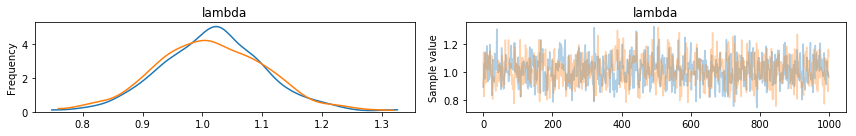

In [19]:
with strawman_model:
    pm.traceplot(trace);


In [15]:
# linear regression model setup

followers_train = []
retweets_train = []
followers_test = []
retweets_test = []

for i in range(len(root_tweet_names)):
    count = int(tweet_dfs[i].iloc[0]["FollowerCount"])
    if partitions[1][i]: # currently hard-coded to look at first partition
        followers_train.append(count)
        retweets_train.append(len(tweet_dfs[i]) - 1) 
    else:
        followers_test.append(count)
        retweets_test.append(len(tweet_dfs[i]) - 1) 

followers_train_log = np.log(np.array(followers_train))
retweets_train_log = np.log(np.array(retweets_train))

followers_test_log = np.log(np.array(followers_test))
retweets_test_log = np.log(np.array(retweets_test))

data = dict(x = followers_train_log, y = retweets_train_log)

In [16]:
with pm.Model() as linear_regression_model:
    # Define priors
    sigma = pm.HalfCauchy('sigma', beta=10, testval=1.)
    beta_0 = pm.Normal('beta_0', 0, sd=20)
    beta_1 = pm.Normal('beta_1', 0, sd=20)
        
    e_x = pm.Normal("e", 0, sd = 1, shape = (len(followers_train_log),1))

    # Define likelihood    
    likelihood = pm.Normal('y', mu=beta_0 + beta_1 * followers_train_log + e_x,
                        sd=sigma, observed=retweets_train_log)

In [48]:
# Run and fit our model
with linear_regression_model:
#     step = pm.Metropolis()
    trace = pm.sample(5000, tune=2000, chains=5, cores=4)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (5 chains in 2 jobs)
NUTS: [e, beta_1, beta_0, sigma_log__]
100%|██████████| 6000/6000 [01:19<00:00, 75.61it/s]
The acceptance probability does not match the target. It is 0.882557937621, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


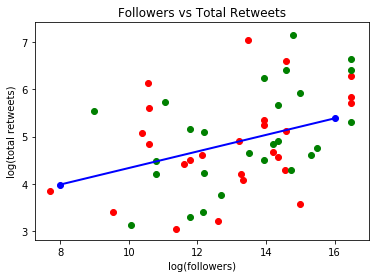

In [49]:
# Plot outputs



x_line = [8,16]
y_line = []

b_0 = np.mean(trace['beta_0'])
b_1 = np.mean(trace['beta_1'])
for val in x_line:
    y_line.append(val*b_1 + b_0)

fig, ax = plt.subplots()
plt.scatter(followers_train_log, retweets_train_log,  color='red')
plt.scatter(followers_test_log, retweets_test_log,  color='green')
plt.plot(x_line, y_line, 'bo-', label='line 1', linewidth=2)

ax.set_title('Followers vs Total Retweets')

ax.set_xlabel('log(followers)')
ax.set_ylabel('log(total retweets)')

plt.show()

In [51]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
beta_0,2.589945,0.295976,0.004792,2.019163,3.176410,3864.0,1.000117
beta_1,0.174576,0.016928,0.000179,0.140604,0.206644,10436.0,0.999984
e__0_0,-0.000450,0.265659,0.004182,-0.518224,0.530478,3940.0,1.000090
e__1_0,0.000866,0.265414,0.004336,-0.517981,0.512977,4006.0,1.000156
e__2_0,0.000164,0.269152,0.004318,-0.527188,0.525241,4043.0,1.000082
e__3_0,-0.000314,0.265776,0.004207,-0.552163,0.492235,3983.0,1.000151
e__4_0,0.000532,0.265360,0.004068,-0.510683,0.525568,4074.0,1.000270
e__5_0,0.001826,0.269010,0.004235,-0.520233,0.535108,4101.0,1.000057
e__6_0,-0.000325,0.268457,0.004376,-0.520849,0.535398,3961.0,1.000262
e__7_0,-0.001323,0.266004,0.004197,-0.508603,0.526049,4097.0,1.000178


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f39dc6dc610>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f39dc51b4d0>]], dtype=object)

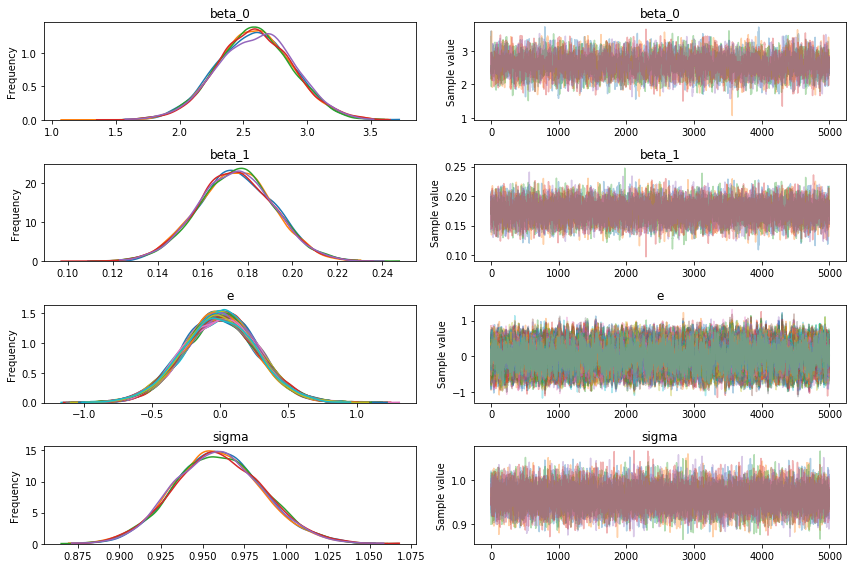

In [50]:
pm.traceplot(trace)

In [38]:
len(tweet_dfs[key])

1261

In [55]:
# APE

# beta_0 + beta_1 * followers_train_log

b_0_list = trace['beta_0']
b_1_list = trace['beta_1']

APE = {} #key is the ith prediction tweet, value is an array of APE indexed by time

for key in range(len(partitions[1].keys())):
    if not partitions[1][key]:
        pred = b_0_list + b_1_list * np.log(tweet_dfs[key].iloc[0]["FollowerCount"])
        rts = np.log(len(tweet_dfs[key]))
        diff = np.absolute((rts - pred)/rts)
        APE[key] = np.average(diff)
        
print APE

mape = 0
for i in APE:
    mape += APE[i]
mape = mape / len(APE)
print mape

{0: 0.19964190197936593, 4: 0.36822584198232589, 6: 0.39507159815049664, 8: 0.37276277409679476, 10: 0.26974582471481895, 12: 0.065287660441687559, 14: 0.11142383878841323, 17: 0.035977513716090148, 19: 0.11159034627612097, 22: 0.14084047368559732, 23: 0.062032414819816341, 25: 0.1097950928123988, 26: 0.051796962068300437, 28: 0.046331427325563612, 30: 0.075139406208106718, 32: 0.10092056810696028, 34: 0.039440776989986409, 36: 0.25019064596266094, 37: 0.10021418985521821, 39: 0.21029479930263434, 41: 0.11902053620847693, 43: 0.19319221759277286, 45: 0.19896684911331006, 47: 0.14764577190194988, 49: 0.17714522159152354, 51: 0.27581855098563113}
0.162635123257


In [16]:
# alternative model 
with pm.Model() as glm_model:
    pm.glm.GLM.from_formula('y ~ x', data)
    trace = pm.sample(1000, tune=3000, cores=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd_log__, x, Intercept]
100%|██████████| 4000/4000 [00:11<00:00, 345.50it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa7a008e9d0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7fa79f194b50>]], dtype=object)

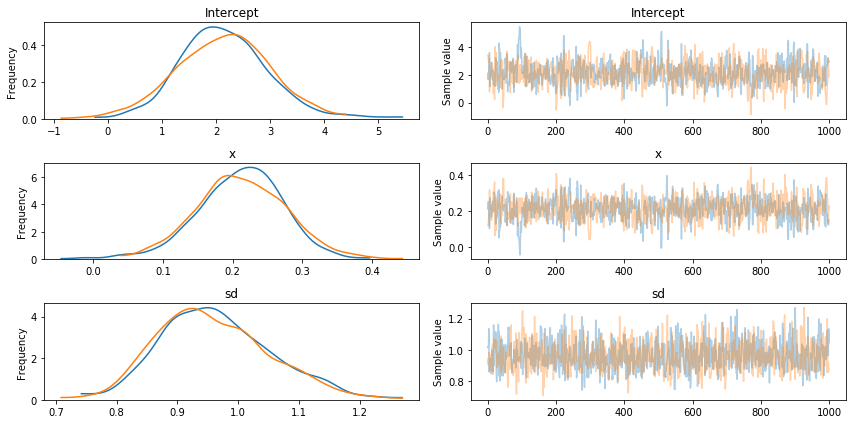

In [17]:
pm.traceplot(trace)

In [94]:
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score


In [96]:
followers_array_log = np.array(followers_array, ndmin=2)
followers_array_log = np.transpose(np.log(followers_array_log))

retweets_array_log = np.array(retweets_array, ndmin=2)
retweets_array_log = np.transpose(np.log(retweets_array_log))

In [97]:
# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(followers_array_log, retweets_array_log)

# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean squared error
# print("Mean squared error: %.2f"
#       % mean_squared_error(diabetes_y_test, diabetes_y_pred))
# # Explained variance score: 1 is perfect prediction
# print('Variance score: %.2f' % r2_score(diabetes_y_test, diabetes_y_pred))

('Coefficients: \n', array([[ 0.2106125]]))
